# SVM soft-margin

### Prediction

$$
\begin{align*}
h(\mathbf{x}) &= \mathbf{w^\intercal x} + b \\
y &= \text{sgn}(h(\mathbf{x}))
\end{align*}
$$

### Hinge loss
$$
\begin{align*}
L(y, h(\mathbf{x})) &= \begin{cases}
        0 & \text{if } y h(\mathbf{x}) \geq 1\\
        1 - y h(\mathbf{x}) & \text{else }
    \end{cases} \\
&= \max{(0, 1 - y h(\mathbf{x}))} \\
\end{align*}
$$

### Hinge loss partial derivatives
$$
\begin{align*}
\frac{\partial L}{\partial \mathbf{w}} &= \begin{cases}
        0 & \text{if } y h(\mathbf{x}) \geq 1\\
        -y \mathbf{x} & \text{else }
    \end{cases} \\
\frac{\partial L}{\partial b} &= \begin{cases}
        0 & \text{if } y h(\mathbf{x}) \geq 1\\
        -y & \text{else }
    \end{cases} \\
\end{align*}
$$

### Error function
$$
\begin{align*}
E(\mathbf{w}|\mathcal{D}) &= \frac{\lambda}{2} ||\mathbf{w}||^2 + \frac{1}{N} \sum_{i=1}^{N} L(y_i, h(\mathbf{x_i})) \\
&= \frac{\lambda}{2} ||\mathbf{w}||^2 + \frac{1}{N} \sum_{i=1}^{N} \max{(0, 1 - y_i h(\mathbf{x_i}))} \\
&= \frac{\lambda}{2} \mathbf{w}^\intercal \mathbf{w} + \frac{1}{N} \sum_{i=1}^{N} \max{(0, 1 - y_i h(\mathbf{x_i}))}
\end{align*}
$$

### Error function gradients
$$
\begin{align*}
\frac{\partial E}{\partial \mathbf{w}} &= 
        \begin{cases}
        \lambda \mathbf{w} & \text{if } y h(\mathbf{x}) \geq 1\\
        \lambda \mathbf{w} -y \mathbf{x} & \text{else }
    \end{cases} \\
\frac{\partial E}{\partial b} &= 
        \begin{cases}
        0 & \text{if } y h(\mathbf{x}) \geq 1\\
        -y  & \text{else }
    \end{cases} \\

\end{align*}
$$

### Gradient descent updates
$$
\begin{align*}
\mathbf{w}_{t + 1} &= \mathbf{w}_{t} - \alpha \frac{\partial E}{\partial \mathbf{w}} \\
b_{t + 1} &= b_t - \alpha \frac{\partial E}{\partial b}
\end{align*}
$$

***

# Kernel SVM

### Dual problem
$$\max_{\alpha} \sum_{i=1}^{N} \alpha_i - \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j (\mathbf{x}_i \cdot \mathbf{x}_j)$$

### We can replace the dot product $\mathbf{x}_i \cdot \mathbf{x}_j$ with a kernel function $\kappa(\mathbf{x}_i, \mathbf{x}_j)$
$$\max_{\alpha} \sum_{i=1}^{N} \alpha_i - \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j \kappa(\mathbf{x}_i, \mathbf{x}_j)$$

### Prediction 
$$h(\mathbf{x}) = \sum_{i=1}^{N}\alpha_i y_i \kappa(\mathbf{x}, \mathbf{x}_i) + b$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

In [3]:
class SoftSVM:

    def __init__(self, lambda_param=1e-2, lr=1e-2, max_iter=1000):
        self.lambda_param = lambda_param
        self.lr = lr
        self.max_iter = max_iter
        self.weights = None
        self.bias = 0

    def hinge_loss(self, X, y):
        return np.maximum(0, 1 - y * np.dot(X, self.weights))

    def error(self, X, y):
        return 0.5 * self.lambda_param * np.sum(self.weights ** 2) + np.mean(self.hinge_loss(X, y))
    
    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def predict(self, X):
        prediction = np.dot(X, self.weights) + self.bias
        return np.sign(prediction)

    def fit(self, X, y):

        y = np.where(y <= 0, -1, 1)
        if len(y.shape) != 1:
            y = y.reshape(-1)

        n_features = X.shape[1]
        self.weights = np.zeros(n_features)

        for _ in range(self.max_iter):

            for idx, x in enumerate(X):

                y_pred = np.dot(x, self.weights) + self.bias

                condition = y[idx] * y_pred >= 1

                if condition:
                    dw = self.lambda_param * self.weights
                    self.weights -= self.lr * dw
                else:
                    dw = self.lambda_param * self.weights - y[idx] * x
                    db = -y[idx]
                    self.weights -= self.lr * dw
                    self.bias -= self.lr * db

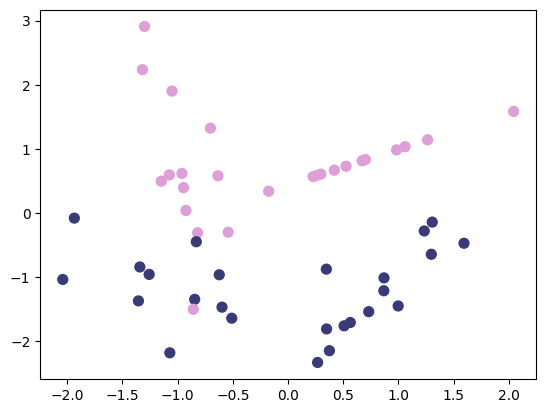

In [18]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=50, n_informative=2, n_features=2, n_redundant=0, n_clusters_per_class=2)
y = np.where(y <= 0, -1, 1)
plot_2d_clf_problem(X, y)

Accuracy: 0.92


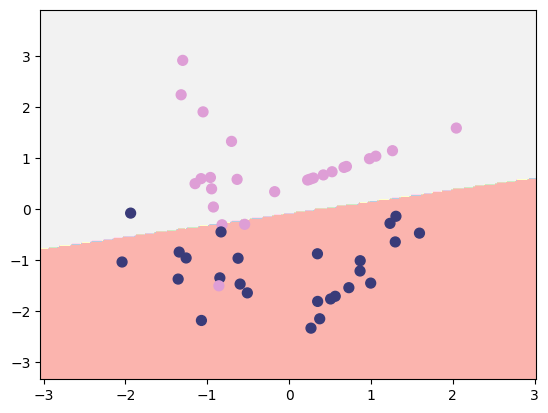

In [19]:
model = SoftSVM(lambda_param=0, lr = 1e-3, max_iter=1000)
model.fit(X, y)
y_pred = model.predict(X)
print(f'Accuracy: {model.accuracy(X, y)}')
plot_2d_clf_problem(X, y, model.predict)

In [20]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers

class KernelSVM:

    def __init__(self, kernel='linear', C=None):
        self.kernels = {'linear': self._linear_kernel,
                        'poly': self._polynomial_kernel,
                        'rbf': self._gaussian_kernel}
        self.kernel = self.kernels[kernel]
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples), tc='d')
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        #print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == self._linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))
    
    def _linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def _polynomial_kernel(self, x, y, p=3):
        return (1 + np.dot(x, y)) ** p

    def _gaussian_kernel(self, x, y, sigma=5.0):
        return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))
    
    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

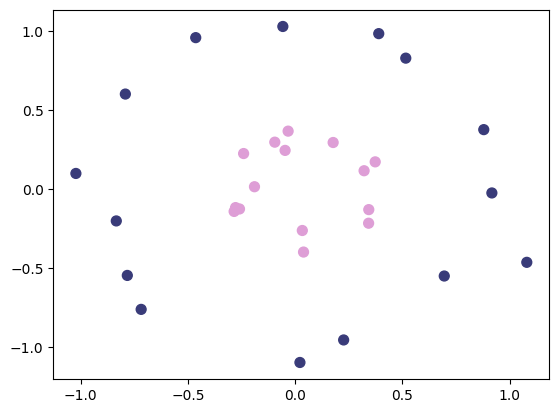

In [21]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=30, factor=0.3, noise=0.1)
y = np.where(y != 0, 1, -1)
plot_2d_clf_problem(X, y)

     pcost       dcost       gap    pres   dres
 0: -2.9788e+01 -5.9822e+01  3e+01  9e-16  2e+00
 1: -7.2885e+01 -7.4287e+01  1e+00  2e-15  1e+00
 2: -1.5161e+02 -1.5556e+02  4e+00  5e-15  1e+00
 3: -3.5322e+02 -3.6830e+02  2e+01  2e-14  1e+00
 4: -8.2624e+02 -8.8891e+02  6e+01  4e-14  1e+00
 5: -1.8154e+03 -2.0578e+03  2e+02  1e-13  9e-01
 6: -3.6987e+03 -4.4902e+03  8e+02  3e-13  8e-01
 7: -5.4821e+03 -6.5631e+03  1e+03  1e-12  4e-01
 8: -5.9873e+03 -6.1513e+03  2e+02  1e-12  3e-02
 9: -6.0618e+03 -6.0798e+03  2e+01  1e-12  2e-03
10: -6.0691e+03 -6.0700e+03  1e+00  2e-12  5e-05
11: -6.0697e+03 -6.0698e+03  4e-02  2e-12  5e-07
12: -6.0698e+03 -6.0698e+03  4e-04  3e-12  5e-09
Optimal solution found.
Accuracy: 1.0


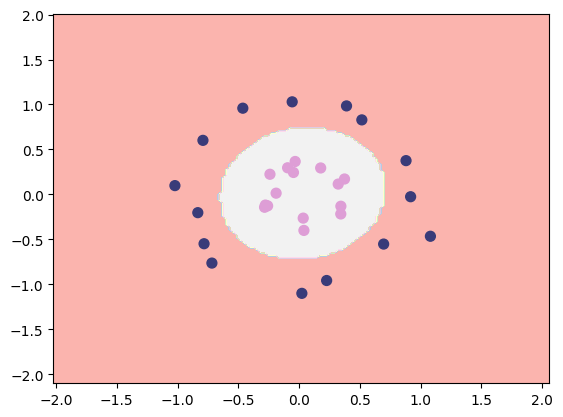

In [22]:
model = KernelSVM(kernel='rbf')
model.fit(X, y)
y_pred = model.predict(X)
print(f'Accuracy: {model.accuracy(X, y)}')
plot_2d_clf_problem(X, y, model.predict)